In [1]:
# gpu 0번 연결해두기!
import os

import torchsummary

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '7,' # gpu 번호를 선택

import torch

x = torch.rand([5,10], device='cuda:0')
print(x)
device='cuda:0'

tensor([[0.4035, 0.9317, 0.9386, 0.7088, 0.9203, 0.1808, 0.2871, 0.1062, 0.5220,
         0.0881],
        [0.8626, 0.4747, 0.4153, 0.3861, 0.6923, 0.3733, 0.6315, 0.8155, 0.7099,
         0.7968],
        [0.5849, 0.4506, 0.9610, 0.9857, 0.2244, 0.4217, 0.4199, 0.3248, 0.3270,
         0.2210],
        [0.2370, 0.5885, 0.1001, 0.1333, 0.8401, 0.4060, 0.6610, 0.2370, 0.9003,
         0.2938],
        [0.4695, 0.4550, 0.5709, 0.1414, 0.2989, 0.3384, 0.7261, 0.6519, 0.1912,
         0.0409]], device='cuda:0')


## 패키지 불러오기

In [2]:
import os
import sys
import pickle

import matplotlib.pyplot as plt
import numpy
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from tqdm.auto import trange
from PIL import Image

import matplotlib.pyplot as plt
import time
import copy
import cv2
import random

import pandas as pd
import glob
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
import torchsummary

import warnings
warnings.filterwarnings('ignore')



In [5]:
print(1.float())

SyntaxError: invalid syntax (2496277846.py, line 1)

In [10]:
del float

NameError: name 'float' is not defined

In [4]:
import numpy as np
print(np.random.random()<1)

True


## 데이터 불러오기 및 전처리

### CustomDataset class 만들기

In [ ]:
class Train_dataset(Dataset):
    def __init__(self, path, transform=None):
        with open(os.path.join(path,'train'),'rb') as f:
            data=pickle.load(f,encoding='bytes')
        self.transform = transform
        self.img=data[b'data']
        self.label=data[b'fine_labels']
        
        
    def __len__(self):
        return len(self.img)

    def __getitem__(self, index):
        label = self.label[index]
        #~1024 : R채널, 1024~2048 : G채널, 2048~3072 : B채널
        r = self.img[index, :1024].reshape(32, 32)
        g = self.img[index, 1024:2048].reshape(32, 32)
        b = self.img[index, 2048:].reshape(32, 32)
        # dstack 함수는 열 방향으로 값을 붙여주는
        ''' a = np.array([1, 2, 3])
            b = np.array([4, 5, 6])

            np.dstack((a, b)) # shape=(1, 3, 2)
            # array([[[1, 4],
            #         [2, 5],
            #         [3, 6]]])'''
        img = numpy.dstack((r, g, b))

        if self.transform:
            img = self.transform(img)
            
        return img,label
    
    
class Test_dataset(Dataset):
    
    def __init__(self,path,transform=None):
        
        with open(os.path.join(path,'test'),'rb') as f:
            data=pickle.load(f,encoding='bytes')
        self.img=data[b'data']
        self.label=data[b'fine_labels']
        self.transform = transform
        
        
    def __len__(self):
        return len(self.img)
    
    
    def __getitem__(self, index):
        label=self.label[index]
        r = self.img[index, :1024].reshape(32, 32)
        g = self.img[index, 1024:2048].reshape(32, 32)
        b = self.img[index, 2048:].reshape(32, 32)
        img=numpy.dstack((r, g, b))
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

### 데이터 정규화

In [ ]:
train_ds=Train_dataset(path='/home/sinssinej7/shared/hdd_ext/nvme1/public/vision/classification/cifar-100-python',transform=T.ToTensor())
val_ds=Test_dataset(path='/home/sinssinej7/shared/hdd_ext/nvme1/public/vision/classification/cifar-100-python',transform=T.ToTensor())

In [ ]:
train_ds.img.shape

In [ ]:
img,_=train_ds[1]
print(img.shape) # 이미지 형태
print(_) # 해당 이미지의 클래스(라벨)
print(train_ds)
print(val_ds)

In [ ]:
train_meanRGB=[np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds] #이미지의 높이와 너비를 기준으로 평균을 구한다 -> RGB채널별로 이미지의 각 픽셀에 대한 평균이 계산된다.
train_stdRGB=[np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR=np.mean([m[0] for m in train_meanRGB])
train_meanG=np.mean([m[1] for m in train_meanRGB])
train_meanB=np.mean([m[2] for m in train_meanRGB])

train_stdR=np.std([m[0] for m in train_stdRGB])
train_stdG=np.std([m[1] for m in train_stdRGB])
train_stdB=np.std([m[2] for m in train_stdRGB])

val_meanRGB=[np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds] #이미지의 높이와 너비를 기준으로 평균을 구한다 -> RGB채널별로 이미지의 각 픽셀에 대한 평균이 계산된다.
val_stdRGB=[np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR=np.mean([m[0] for m in val_meanRGB])
val_meanG=np.mean([m[1] for m in val_meanRGB])
val_meanB=np.mean([m[2] for m in val_meanRGB])

val_stdR=np.std([m[0] for m in val_stdRGB])
val_stdG=np.std([m[1] for m in val_stdRGB])
val_stdB=np.std([m[2] for m in val_stdRGB])

print(train_meanR,train_meanG,train_meanB)
print(val_meanR,val_meanG,val_meanB)

### 데이터 전처리

In [ ]:
def resize_img(img, img_size=480):
    img_np = np.array(img)

    if img_np.shape[1] > img_np.shape[0]:
        ratio = img_size / img_np.shape[1]
    else:
        ratio = img_size / img_np.shape[0]

    img_np = cv2.resize(img_np, dsize=(0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_LINEAR)

    w, h = img_np.shape[1], img_np.shape[0]
    dw = (img_size - w) / 2
    dh = (img_size - h) / 2

    M = np.float32([[1, 0, dw], [0, 1, dh]])
    img_re = cv2.warpAffine(img_np, M, (img_size, img_size))

    return Image.fromarray(img_re)


In [ ]:
transform_train= T.Compose([#T.Lambda(lambda img: resize_img(img,48)),  # 이미지 리사이즈
                            T.ToPILImage(),
                            T.RandomCrop(32,padding=4),
                            #T.RandomResizedCrop(32,scale=(0.5,1.0)),                         
                            T.AutoAugment(policy=T.autoaugment.AutoAugmentPolicy.CIFAR10, interpolation=T.InterpolationMode.BICUBIC),
                            T.RandomHorizontalFlip(p=0.8),  # p확률로 좌우반전
                            #T.ColorJitter(brightness=0.2, contrast=0.2,hue=0.2,saturation=0.2),  # 이미지 지터링
                            #T.RandomVerticalFlip(p=0.5),  # p확률로 상하반전
                            T.ToTensor(),
                            T.Normalize(mean=[train_meanR, train_meanG, train_meanB], std=[train_stdR,train_stdG ,train_stdB])])
                            


transform_val = T.Compose([#T.Lambda(lambda img: resize_img(img,48)),  # 이미지 resize
                            T.ToPILImage(),
                            T.CenterCrop((32,32)),
                            T.ToTensor(),
                            T.Normalize(mean=[val_meanR, val_meanG, val_meanB], std=[val_stdR, val_stdG, val_stdB])])


train_ds.transform=transform_train
train_loader=DataLoader(train_ds,batch_size=512,shuffle=True,drop_last=True)
val_ds.transform=transform_val
val_loader=DataLoader(val_ds,batch_size=512,shuffle=False)


In [10]:
print(len(train_ds))

50000


In [11]:
len(train_loader)

97

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])


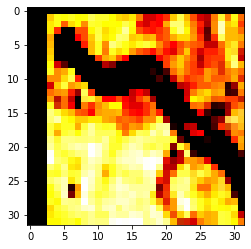

In [12]:
for idx, (img,label) in enumerate(train_loader):
  print(img.shape)
  plt.imshow(img[20].permute(1,2,0))
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])


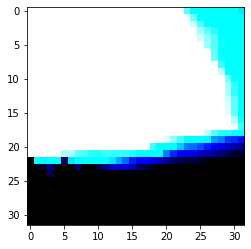

In [13]:
for idx, (img,label) in enumerate(val_loader):
  print(img.shape)
  plt.imshow(img[8].permute(1,2,0))
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


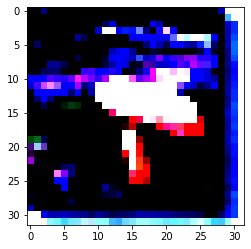

In [14]:
plt.imshow(img[3].permute(1,2,0).cpu())


## 모델 훈련

In [15]:
def val(val_loader, model, loss_fn,device):
    model.eval()
    with torch.no_grad():
        r_loss=0
        corr=0
        
        for idx, (img,label) in enumerate(val_loader):
            
            img,label=img.to(device), label.to(device)
            
            output=model(img)
            
            _,pred=output.max(dim=1)
            corr+=torch.sum(pred.eq(label)).item()
            
            r_loss+=loss_fn(output,label).item()*img.size(0)
            
        acc = corr/len(val_loader.dataset)
        
        return r_loss/len(val_loader.dataset), acc
        
        

### Cutmix

In [16]:
def rand_bbox(size, lam): # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = np.int(W * cut_rat)  # 패치의 너비
    cut_h = np.int(H * cut_rat)  # 패치의 높이

    # uniform
    # 이미지 내에서 랜덤한 중심 좌표 추출
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치의 좌표값 계산 및 이미지 범위 조
    bbx1 = np.clip(cx - cut_w // 2, 0, W)  # cx: 이미지 내엣 랜덤하게 선택된 중심 x좌표, 'cut_x'는 패치의 너비의 절반
    #왼쪽 모서리의 x 좌표 (bbx1)를 계산
    #cx - cut_w // 2는 중심 좌표에서 패치의 왼쪽 끝으로 이동한 좌표
    #cx - cut_w // 2 이 값이 -20이 나오면 값이 0 , 이미지를 벗어나지 않게끔 하기 위해서 계산 값이 - 면 0, 이미지 너비보다 크면 W
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [17]:
img,label = next(iter(train_loader))
img,label=img.to(device),label.to(device)

lam = np.random.beta(1.0, 1.0)  # 베타 분포에서 lam 값을 가져옵나다.
rand_index = torch.randperm(img.size()[0]).to(device) # batch_size 내의 인덱스가 랜덤하게 셔플됩니다.
shuffled_y = label[rand_index] # 타겟 레이블을 랜덤하게 셔플합니다.

bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
img[:,:,bbx1:bbx2, bby1:bby2] = img[rand_index,:,bbx1:bbx2, bby1:bby2]

lam = 1-((bbx2-bbx1)*(bby2-bby1)/(img.size()[-1]*img.size()[-2])) # 픽셀 비율과 일치하도록 람다 조정


In [18]:
lam

0.984375

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


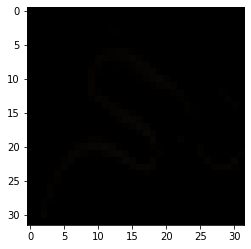

In [19]:
img_normalized = img[21].permute(1, 2, 0).cpu().numpy() / 255.0  # 이미지를 [0, 1] 범위로 정규화

plt.imshow(img_normalized)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


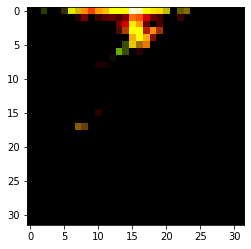

In [20]:
plt.imshow(img[3].permute(1,2,0).cpu())

In [21]:
def train(train_loader, model, loss_fn, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정
    r_loss = 0
    corr = 0
    r_size = 0
    

    progress_bar = tqdm(train_loader)
    for idx, (img,label) in enumerate(progress_bar):
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()
        
        
        if 1.0 > 0 and np.random.random()>1: # 전부 cutmix 하기
            lam= np.random.beta(1.0,1.0)
            rand_index = torch.randperm(img.size()[0]).to(device)
            target_a = label
            target_b = label[rand_index]
            bbx1,bby1,bbx2,bby2= rand_bbox(img.size(),lam)

            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))

            output=model(img)
            loss= loss_fn(output,target_a)* lam + loss_fn(output,target_b)*(1-lam)

        else:
            output = model(img)
            loss = loss_fn(output,label)
            

        loss.backward()
        optimizer.step()

        _, pred = output.max(dim=1) 
        corr += pred.eq(label).sum().item() 
        r_loss += loss.item() 
        r_size += img.size(0) 

        accuracy = corr*100 / r_size
        
        avg_cost=r_loss/(idx+1)
        
        progress_bar.set_description(f'[Training] loss: {r_loss/(idx+1):.4f}, accuracy: {accuracy:.4f}')

    return avg_cost,accuracy



### Resnet 구현해보기

In [22]:
class ResidualBlock(nn.Module):
    
    def __init__(self, input=64, output=64,stride=1):
        super(ResidualBlock, self).__init__()
        
        self.input = input
        self.output = output
        self.stride = stride
        
        self.layer = nn.Sequential(
            nn.Conv2d(input, output, kernel_size=1,bias=False),
            nn.BatchNorm2d(output),
            nn.ReLU(),
            nn.Conv2d(output, output, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(output),
            nn.ReLU(),
            nn.Conv2d(output, output*4, kernel_size=1, bias=False),
            nn.BatchNorm2d(output*4))
        
        self.projection = nn.Sequential(
            nn.Conv2d(input, output*4, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(output*4))                           

    def forward(self, x):
        identity = x
        x = self.layer(x)
        if self.input != self.output*4:
            identity = self.projection(identity)
        x += identity
        return x


In [23]:
class Resnet(nn.Module):
    
    def __init__(self,input=3,num_classes=100):
        super(Resnet,self).__init__()

        self.input = input
        self.conv1=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.conv2=self._make_layer(64,64,3,1)
        self.conv3=self._make_layer(256,128,4,2)
        self.conv4=self._make_layer(512,256,6,2)
        self.conv5=self._make_layer(1024,512,3,2)
        
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
        
        for m in self.modules():
          if isinstance(m,nn.Conv2d): # Conv층 초기화
            nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') #kaming_normal 분포로 가중치 초기화
            if m.bias is not None:
              nn.init.constant_(m.bias,0) # init_constant_상수로 초기화
          elif isinstance(m,nn.BatchNorm2d):# BatchNorm 초기화
            nn.init.constant_(m.weight,1)
            nn.init.constant_(m.bias,0)
          elif isinstance(m,nn.Linear):# Linear층 초기화
            nn.init.normal_(m.weight,0,0.01) # 평균이 0이고, 표준편차가 0.01 분포로 설
            nn.init.constant_(m.bias,0)                 
        
    
    def _make_layer(self,input_ch,output,num,stride):
        layers=[]
        # 첫 번째 ResidualBlock 생성 시 입력 채널 수와 출력 채널 수를 설정합니다.
        layers.append(ResidualBlock(input_ch, output,stride))
        input_ch = output * 4  # 다음 레이어의 입력 채널 수를 설정하기 위해 업데이트합니다.
        for _ in range(num-1):
            # 나머지 ResidualBlock들을 생성할 때도 입력 채널 수와 출력 채널 수를 설정합니다.
            layers.append(ResidualBlock(input_ch, output))
        return nn.Sequential(*layers)
        
    def forward(self,x):
        output=self.conv1(x)
        output=self.conv2(output)
        output=self.conv3(output)
        output=self.conv4(output)
        output=self.conv5(output)
        output=self.avg_pool(output)
        output=output.view(output.size(0),-1)
        output=self.fc(output)
        
        return output


In [64]:
model=Resnet()
model.to(device)

torchsummary.summary(model,input_size=(3,32,32),device='cuda')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
    ResidualBlock-14          [-1, 256,

In [25]:
%mkdir './models3'

mkdir: cannot create directory ‘./models3’: File exists


In [65]:
cri=nn.CrossEntropyLoss()
optimizer=torch.optim.NAdam(model.parameters(),lr=1e-3,weight_decay=1e-4)

# 학습률 확인
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=3, threshold=1e-3) # val_loss가 3번 이상 가장 좋은 것보다 안 좋아지면 leargning rate 조절 #factor을 0.1로 하면 계속 71.~에 더 이상 오르지 않음
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=0.000001) 

#코사인러닝으로 바꿔보기
best_loss=float('inf')

start_time = time.time()  # 코드 실행 시작 시간 기록

loss_history={
        'train':[],
        'val':[],}

metric_history={
        'train':[],
        'val':[],}

epochs = 200
for epoch in range(epochs + 1):
    
    current_lr=get_lr(optimizer)
    
    print('Epoch={}/{},currnet lr={}'.format(epoch,epochs-1,current_lr))

    avg_cost,accuracy = train(train_loader, model, cri, optimizer, device)
    loss_history['train'].append(avg_cost)
    metric_history['train'].append(accuracy)
    
    val_loss, val_acc = val(val_loader,model,cri,device)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_acc)
    scheduler.step() 
    
    
    print(val_loss,val_acc)

    end_time = time.time()  # 코드 실행 종료 시간 기록
    execution_time = end_time - start_time  # 실행 시간 계산

    if val_loss<best_loss:
        best_loss=val_loss
        best_model_wts=copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(),'/home/sinssinej7/private/my_first_pycharm/models3/weights6.pt')
        print('Copied best model weights!')
    
    hours = int(execution_time // 3600)
    minutes = int((execution_time % 3600) // 60)

    print("Execution Time:", hours, "시간", minutes, "분")


Epoch=0/199,currnet lr=0.001


[Training] loss: 4.2120, accuracy: 7.3792: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


3.924207978439331 0.1225
Copied best model weights!
Execution Time: 0 시간 1 분
Epoch=1/199,currnet lr=0.0009997535269026829


[Training] loss: 3.6784, accuracy: 14.8926: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


3.7001752433776853 0.1763
Copied best model weights!
Execution Time: 0 시간 2 분
Epoch=2/199,currnet lr=0.0009990143508499217


[Training] loss: 3.3013, accuracy: 21.2036: 100%|██████████| 48/48 [01:09<00:00,  1.46s/it]


3.2898125312805178 0.2184
Copied best model weights!
Execution Time: 0 시간 3 분
Epoch=3/199,currnet lr=0.0009977832013192385


[Training] loss: 2.8860, accuracy: 28.5583: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


2.8376904624938963 0.3149
Copied best model weights!
Execution Time: 0 시간 4 분
Epoch=4/199,currnet lr=0.0009960612933065818


[Training] loss: 2.6011, accuracy: 34.2468: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


2.5347227588653563 0.3643
Copied best model weights!
Execution Time: 0 시간 6 분
Epoch=5/199,currnet lr=0.0009938503261272714


[Training] loss: 2.3505, accuracy: 39.3636: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


2.679584097671509 0.3599
Execution Time: 0 시간 7 분
Epoch=6/199,currnet lr=0.00099115248173898


[Training] loss: 2.1828, accuracy: 42.7327: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


2.179368307495117 0.4414
Copied best model weights!
Execution Time: 0 시간 8 분
Epoch=7/199,currnet lr=0.0009879704225884043


[Training] loss: 2.0242, accuracy: 46.6044: 100%|██████████| 48/48 [01:08<00:00,  1.44s/it]


1.8879806234359742 0.4952
Copied best model weights!
Execution Time: 0 시간 9 분
Epoch=8/199,currnet lr=0.0009843072889837512


[Training] loss: 1.8893, accuracy: 49.5178: 100%|██████████| 48/48 [01:08<00:00,  1.44s/it]


2.2761821266174316 0.4339
Execution Time: 0 시간 11 분
Epoch=9/199,currnet lr=0.000980166695995633


[Training] loss: 1.7903, accuracy: 51.6296: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.9694510005950927 0.482
Execution Time: 0 시간 12 분
Epoch=10/199,currnet lr=0.0009755527298894294


[Training] loss: 1.6927, accuracy: 53.9083: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.6919712135314942 0.5466
Copied best model weights!
Execution Time: 0 시간 13 분
Epoch=11/199,currnet lr=0.0009704699440926358


[Training] loss: 1.6030, accuracy: 56.0445: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.5246440818786622 0.5719
Copied best model weights!
Execution Time: 0 시간 14 분
Epoch=12/199,currnet lr=0.0009649233547011817


[Training] loss: 1.5404, accuracy: 57.6029: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.7679595342636107 0.5306
Execution Time: 0 시간 15 분
Epoch=13/199,currnet lr=0.0009589184355291487


[Training] loss: 1.4833, accuracy: 59.0902: 100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


1.6984009771347046 0.5597
Execution Time: 0 시간 17 분
Epoch=14/199,currnet lr=0.000952461112706777


[Training] loss: 1.4259, accuracy: 60.5042: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.8527996171951293 0.5398
Execution Time: 0 시간 18 분
Epoch=15/199,currnet lr=0.00094555775883209


[Training] loss: 1.3634, accuracy: 61.9344: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.6314411849975585 0.5662
Execution Time: 0 시간 19 분
Epoch=16/199,currnet lr=0.0009382151866819101


[Training] loss: 1.3162, accuracy: 63.1185: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.6472915939331054 0.5764
Execution Time: 0 시간 20 분
Epoch=17/199,currnet lr=0.0009304406424884702


[Training] loss: 1.2658, accuracy: 64.4552: 100%|██████████| 48/48 [01:08<00:00,  1.44s/it]


1.5279567598342896 0.5926
Execution Time: 0 시간 21 분
Epoch=18/199,currnet lr=0.000922241798788257


[Training] loss: 1.2287, accuracy: 65.3300: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.4383240982055665 0.6131
Copied best model weights!
Execution Time: 0 시간 23 분
Epoch=19/199,currnet lr=0.0009136267468501441


[Training] loss: 1.1852, accuracy: 66.5263: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.5941800022125243 0.5966
Execution Time: 0 시간 24 분
Epoch=20/199,currnet lr=0.0009046039886902867


[Training] loss: 1.1487, accuracy: 67.2648: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.501122912979126 0.6098
Execution Time: 0 시간 25 분
Epoch=21/199,currnet lr=0.0008951824286816577


[Training] loss: 1.1047, accuracy: 68.3329: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.4761498617172242 0.6027
Execution Time: 0 시간 26 분
Epoch=22/199,currnet lr=0.0008853713647665071


[Training] loss: 1.0765, accuracy: 69.3766: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.4341156158447266 0.6235
Copied best model weights!
Execution Time: 0 시간 28 분
Epoch=23/199,currnet lr=0.0008751804792804149


[Training] loss: 1.0487, accuracy: 69.9727: 100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


1.5196635036468507 0.6125
Execution Time: 0 시간 29 분
Epoch=24/199,currnet lr=0.0008646198293969954


[Training] loss: 1.0124, accuracy: 71.1019: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.4480006826400758 0.6287
Execution Time: 0 시간 30 분
Epoch=25/199,currnet lr=0.0008536998372026807


[Training] loss: 0.9767, accuracy: 72.0886: 100%|██████████| 48/48 [01:10<00:00,  1.46s/it]


1.398794722175598 0.641
Copied best model weights!
Execution Time: 0 시간 31 분
Epoch=26/199,currnet lr=0.0008424312794113804


[Training] loss: 0.9472, accuracy: 72.7519: 100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


1.2866566789627074 0.6571
Copied best model weights!
Execution Time: 0 시간 33 분
Epoch=27/199,currnet lr=0.0008308252767291644


[Training] loss: 0.9217, accuracy: 73.3195: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.3830879920959473 0.6426
Execution Time: 0 시간 34 분
Epoch=28/199,currnet lr=0.0008188932828794708


[Training] loss: 0.9008, accuracy: 74.0540: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.2695859350204468 0.6573
Copied best model weights!
Execution Time: 0 시간 35 분
Epoch=29/199,currnet lr=0.0008066470732996621


[Training] loss: 0.8652, accuracy: 75.1485: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.260751639175415 0.6681
Copied best model weights!
Execution Time: 0 시간 36 분
Epoch=30/199,currnet lr=0.0007940987335200907


[Training] loss: 0.8497, accuracy: 75.3845: 100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


1.3735300443649292 0.6499
Execution Time: 0 시간 37 분
Epoch=31/199,currnet lr=0.0007812606472371396


[Training] loss: 0.8227, accuracy: 76.3407: 100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


1.3893105243682862 0.6471
Execution Time: 0 시간 39 분
Epoch=32/199,currnet lr=0.0007681454840920091


[Training] loss: 0.8015, accuracy: 76.6805: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.281030525779724 0.6655
Execution Time: 0 시간 40 분
Epoch=33/199,currnet lr=0.0007547661871673109


[Training] loss: 0.7780, accuracy: 77.5228: 100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


1.339356131362915 0.6733
Execution Time: 0 시간 41 분
Epoch=34/199,currnet lr=0.0007411359602138072


[Training] loss: 0.7464, accuracy: 78.4729: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.202643960380554 0.6866
Copied best model weights!
Execution Time: 0 시간 42 분
Epoch=35/199,currnet lr=0.000727268254619904


[Training] loss: 0.7375, accuracy: 78.7292: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.2538892673492432 0.677
Execution Time: 0 시간 43 분
Epoch=36/199,currnet lr=0.0007131767561367542


[Training] loss: 0.7127, accuracy: 79.2725: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.1976861164093018 0.6885
Copied best model weights!
Execution Time: 0 시간 45 분
Epoch=37/199,currnet lr=0.0006988753713720732


[Training] loss: 0.7023, accuracy: 79.5959: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.3001581447601318 0.6826
Execution Time: 0 시간 46 분
Epoch=38/199,currnet lr=0.000684378214065997


[Training] loss: 0.6750, accuracy: 80.3955: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.245800083732605 0.6881
Execution Time: 0 시간 47 분
Epoch=39/199,currnet lr=0.0006696995911625234


[Training] loss: 0.6439, accuracy: 81.2642: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.261896071243286 0.6881
Execution Time: 0 시간 48 분
Epoch=40/199,currnet lr=0.0006548539886902865


[Training] loss: 0.6363, accuracy: 81.5979: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.2772604932785034 0.6912
Execution Time: 0 시간 49 분
Epoch=41/199,currnet lr=0.0006398560574665953


[Training] loss: 0.6154, accuracy: 82.2754: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3892405157089234 0.6797
Execution Time: 0 시간 51 분
Epoch=42/199,currnet lr=0.0006247205986388451


[Training] loss: 0.6037, accuracy: 82.6579: 100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


1.3542131242752076 0.6778
Execution Time: 0 시간 52 분
Epoch=43/199,currnet lr=0.0006094625490775733


[Training] loss: 0.5865, accuracy: 83.1014: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2764318424224854 0.6949
Execution Time: 0 시간 53 분
Epoch=44/199,currnet lr=0.0005940969666355698


[Training] loss: 0.5650, accuracy: 83.7240: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.2002162929534912 0.7004
Execution Time: 0 시간 54 분
Epoch=45/199,currnet lr=0.0005786390152875956


[Training] loss: 0.5605, accuracy: 84.0271: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.2155807817459106 0.7093
Execution Time: 0 시간 55 분
Epoch=46/199,currnet lr=0.0005631039501653703


[Training] loss: 0.5389, accuracy: 84.5581: 100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


1.2785529779434204 0.697
Execution Time: 0 시간 57 분
Epoch=47/199,currnet lr=0.0005475071025025981


[Training] loss: 0.5184, accuracy: 85.1644: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.250385515975952 0.7065
Execution Time: 0 시간 58 분
Epoch=48/199,currnet lr=0.0005318638645048923


[Training] loss: 0.5006, accuracy: 85.4960: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2214384832382201 0.7065
Execution Time: 0 시간 59 분
Epoch=49/199,currnet lr=0.0005161896741595253


[Training] loss: 0.4968, accuracy: 85.7422: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.245683118057251 0.7047
Execution Time: 1 시간 0 분
Epoch=50/199,currnet lr=0.0005005000000000002


[Training] loss: 0.4857, accuracy: 86.1410: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.1960335872650147 0.7131
Copied best model weights!
Execution Time: 1 시간 1 분
Epoch=51/199,currnet lr=0.0004848103258404751


[Training] loss: 0.4662, accuracy: 86.6760: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.2380711570739746 0.7103
Execution Time: 1 시간 3 분
Epoch=52/199,currnet lr=0.0004691361354951082


[Training] loss: 0.4558, accuracy: 86.9100: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.1591389003753663 0.7188
Copied best model weights!
Execution Time: 1 시간 4 분
Epoch=53/199,currnet lr=0.00045349289749740224


[Training] loss: 0.4460, accuracy: 87.1541: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2386092681884766 0.713
Execution Time: 1 시간 5 분
Epoch=54/199,currnet lr=0.0004378960498346302


[Training] loss: 0.4313, accuracy: 87.6892: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.2309029182434081 0.7105
Execution Time: 1 시간 6 분
Epoch=55/199,currnet lr=0.0004223609847124048


[Training] loss: 0.4265, accuracy: 87.8886: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.189794944190979 0.7151
Execution Time: 1 시간 7 분
Epoch=56/199,currnet lr=0.0004069030333644307


[Training] loss: 0.4071, accuracy: 88.5010: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.175274185180664 0.7277
Execution Time: 1 시간 9 분
Epoch=57/199,currnet lr=0.0003915374509224273


[Training] loss: 0.3935, accuracy: 88.7817: 100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


1.1489722829818725 0.7351
Copied best model weights!
Execution Time: 1 시간 10 분
Epoch=58/199,currnet lr=0.0003762794013611551


[Training] loss: 0.3935, accuracy: 89.0381: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.1867345006942749 0.7268
Execution Time: 1 시간 11 분
Epoch=59/199,currnet lr=0.00036114394253340513


[Training] loss: 0.3775, accuracy: 89.2008: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2774490079879761 0.7191
Execution Time: 1 시간 12 분
Epoch=60/199,currnet lr=0.000346146011309714


[Training] loss: 0.3600, accuracy: 89.8966: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.1408814542770385 0.7348
Copied best model weights!
Execution Time: 1 시간 13 분
Epoch=61/199,currnet lr=0.00033130040883747703


[Training] loss: 0.3548, accuracy: 90.1143: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.201953733253479 0.7334
Execution Time: 1 시간 15 분
Epoch=62/199,currnet lr=0.0003166217859340036


[Training] loss: 0.3485, accuracy: 90.1998: 100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


1.1382327436447144 0.7386
Copied best model weights!
Execution Time: 1 시간 16 분
Epoch=63/199,currnet lr=0.0003021246286279271


[Training] loss: 0.3480, accuracy: 90.3056: 100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


1.1072254415512084 0.7425
Copied best model weights!
Execution Time: 1 시간 17 분
Epoch=64/199,currnet lr=0.00028782324386324626


[Training] loss: 0.3406, accuracy: 90.3870: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.1481807235717774 0.7364
Execution Time: 1 시간 18 분
Epoch=65/199,currnet lr=0.00027373174538009644


[Training] loss: 0.3301, accuracy: 90.7837: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.1542692708969116 0.7336
Execution Time: 1 시간 19 분
Epoch=66/199,currnet lr=0.00025986403978619317


[Training] loss: 0.3268, accuracy: 90.9505: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.1318627687454224 0.7397
Execution Time: 1 시간 21 분
Epoch=67/199,currnet lr=0.00024623381283268956


[Training] loss: 0.3102, accuracy: 91.3330: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0771099609375 0.7513
Copied best model weights!
Execution Time: 1 시간 22 분
Epoch=68/199,currnet lr=0.00023285451590799108


[Training] loss: 0.3057, accuracy: 91.5609: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.0905771276474 0.7467
Execution Time: 1 시간 23 분
Epoch=69/199,currnet lr=0.00021973935276286074


[Training] loss: 0.3017, accuracy: 91.6423: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0864586694717406 0.7542
Execution Time: 1 시간 24 분
Epoch=70/199,currnet lr=0.00020690126647990976


[Training] loss: 0.2875, accuracy: 92.0939: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.1141545766830445 0.7444
Execution Time: 1 시간 25 분
Epoch=71/199,currnet lr=0.00019435292670033822


[Training] loss: 0.2787, accuracy: 92.2770: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.1167545265197754 0.7499
Execution Time: 1 시간 27 분
Epoch=72/199,currnet lr=0.0001821067171205295


[Training] loss: 0.2750, accuracy: 92.5557: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.0682411617279053 0.7548
Copied best model weights!
Execution Time: 1 시간 28 분
Epoch=73/199,currnet lr=0.000170174723270836


[Training] loss: 0.2665, accuracy: 92.7043: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0905828050613404 0.7549
Execution Time: 1 시간 29 분
Epoch=74/199,currnet lr=0.00015856872058862001


[Training] loss: 0.2576, accuracy: 92.9749: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.066961367034912 0.7543
Copied best model weights!
Execution Time: 1 시간 30 분
Epoch=75/199,currnet lr=0.00014730016279731957


[Training] loss: 0.2577, accuracy: 92.9525: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.0724899085998536 0.7563
Execution Time: 1 시간 31 분
Epoch=76/199,currnet lr=0.00013638017060300508


[Training] loss: 0.2419, accuracy: 93.3573: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.0579402782440186 0.7586
Copied best model weights!
Execution Time: 1 시간 33 분
Epoch=77/199,currnet lr=0.00012581952071958545


[Training] loss: 0.2454, accuracy: 93.2312: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0319160488128662 0.7583
Copied best model weights!
Execution Time: 1 시간 34 분
Epoch=78/199,currnet lr=0.00011562863523349334


[Training] loss: 0.2431, accuracy: 93.4041: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.0542675704956055 0.7586
Execution Time: 1 시간 35 분
Epoch=79/199,currnet lr=0.00010581757131834266


[Training] loss: 0.2299, accuracy: 93.8049: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.0440087242126466 0.7642
Execution Time: 1 시간 36 분
Epoch=80/199,currnet lr=9.639601130971382e-05


[Training] loss: 0.2241, accuracy: 93.8497: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.0443597270965577 0.7623
Execution Time: 1 시간 37 분
Epoch=81/199,currnet lr=8.737325314985643e-05


[Training] loss: 0.2251, accuracy: 93.7968: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.036434843826294 0.7603
Execution Time: 1 시간 39 분
Epoch=82/199,currnet lr=7.875820121174359e-05


[Training] loss: 0.2200, accuracy: 94.0491: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.0268787986755372 0.7652
Copied best model weights!
Execution Time: 1 시간 40 분
Epoch=83/199,currnet lr=7.05593575115301e-05


[Training] loss: 0.2172, accuracy: 94.0735: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0147225479125976 0.7675
Copied best model weights!
Execution Time: 1 시간 41 분
Epoch=84/199,currnet lr=6.278481331809015e-05


[Training] loss: 0.2116, accuracy: 94.2566: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.0165691360473632 0.769
Execution Time: 1 시간 42 분
Epoch=85/199,currnet lr=5.54422411679103e-05


[Training] loss: 0.2075, accuracy: 94.3604: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0104802698135376 0.7685
Copied best model weights!
Execution Time: 1 시간 43 분
Epoch=86/199,currnet lr=4.853888729322334e-05


[Training] loss: 0.2049, accuracy: 94.4763: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.011048466873169 0.7732
Execution Time: 1 시간 45 분
Epoch=87/199,currnet lr=4.2081564470851536e-05


[Training] loss: 0.2029, accuracy: 94.5516: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


0.9987943839073181 0.7718
Copied best model weights!
Execution Time: 1 시간 46 분
Epoch=88/199,currnet lr=3.6076645298818454e-05


[Training] loss: 0.2031, accuracy: 94.5414: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.0011040539741516 0.7718
Execution Time: 1 시간 47 분
Epoch=89/199,currnet lr=3.053005590736439e-05


[Training] loss: 0.1956, accuracy: 94.7083: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.0028438172340393 0.7715
Execution Time: 1 시간 48 분
Epoch=90/199,currnet lr=2.5447270110570814e-05


[Training] loss: 0.1968, accuracy: 94.6187: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


0.994992474079132 0.7719
Copied best model weights!
Execution Time: 1 시간 49 분
Epoch=91/199,currnet lr=2.0833304004366997e-05


[Training] loss: 0.1856, accuracy: 94.8975: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


0.9967947944641113 0.7709
Execution Time: 1 시간 51 분
Epoch=92/199,currnet lr=1.6692711016248837e-05


[Training] loss: 0.1908, accuracy: 94.7774: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


0.9915508179664612 0.7715
Copied best model weights!
Execution Time: 1 시간 52 분
Epoch=93/199,currnet lr=1.3029577411595715e-05


[Training] loss: 0.1931, accuracy: 94.8669: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


0.9891920598983764 0.7744
Copied best model weights!
Execution Time: 1 시간 53 분
Epoch=94/199,currnet lr=9.847518261019987e-06


[Training] loss: 0.1856, accuracy: 94.9768: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


0.9872819261550904 0.776
Copied best model weights!
Execution Time: 1 시간 54 분
Epoch=95/199,currnet lr=7.14967387272874e-06


[Training] loss: 0.1835, accuracy: 95.1070: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


0.9852245127677918 0.7743
Copied best model weights!
Execution Time: 1 시간 55 분
Epoch=96/199,currnet lr=4.9387066934183575e-06


[Training] loss: 0.1844, accuracy: 95.0114: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


0.9851449328422547 0.7764
Copied best model weights!
Execution Time: 1 시간 57 분
Epoch=97/199,currnet lr=3.2167986807615425e-06


[Training] loss: 0.1862, accuracy: 94.9626: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


0.9854546690940857 0.7759
Execution Time: 1 시간 58 분
Epoch=98/199,currnet lr=1.9856491500783564e-06


[Training] loss: 0.1837, accuracy: 95.1009: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


0.9845649906158447 0.7769
Copied best model weights!
Execution Time: 1 시간 59 분
Epoch=99/199,currnet lr=1.2464730973170658e-06


[Training] loss: 0.1855, accuracy: 95.0521: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


0.9858443651199341 0.7773
Execution Time: 2 시간 0 분
Epoch=100/199,currnet lr=1e-06


[Training] loss: 0.1808, accuracy: 95.1599: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


0.9856033925056458 0.7771
Execution Time: 2 시간 1 분
Epoch=101/199,currnet lr=1.2464730973170658e-06


[Training] loss: 0.1858, accuracy: 94.9626: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


0.9863678633689881 0.7771
Execution Time: 2 시간 3 분
Epoch=102/199,currnet lr=1.9856491500783564e-06


[Training] loss: 0.1785, accuracy: 95.1742: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


0.9844883953094482 0.7751
Copied best model weights!
Execution Time: 2 시간 4 분
Epoch=103/199,currnet lr=3.2167986807615416e-06


[Training] loss: 0.1838, accuracy: 95.0256: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


0.9856243388175965 0.7754
Execution Time: 2 시간 5 분
Epoch=104/199,currnet lr=4.938706693418301e-06


[Training] loss: 0.1843, accuracy: 94.9422: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


0.9847392469406128 0.777
Execution Time: 2 시간 6 분
Epoch=105/199,currnet lr=7.149673872728683e-06


[Training] loss: 0.1847, accuracy: 95.0094: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


0.9845739420890808 0.7769
Execution Time: 2 시간 7 분
Epoch=106/199,currnet lr=9.84751826102004e-06


[Training] loss: 0.1822, accuracy: 95.1599: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


0.9884075610160827 0.7758
Execution Time: 2 시간 9 분
Epoch=107/199,currnet lr=1.3029577411595657e-05


[Training] loss: 0.1852, accuracy: 94.9483: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


0.9836819315910339 0.7736
Copied best model weights!
Execution Time: 2 시간 10 분
Epoch=108/199,currnet lr=1.669271101624872e-05


[Training] loss: 0.1845, accuracy: 94.9931: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


0.9858226021766663 0.7742
Execution Time: 2 시간 11 분
Epoch=109/199,currnet lr=2.0833304004366882e-05


[Training] loss: 0.1833, accuracy: 95.0134: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


0.995107152557373 0.7729
Execution Time: 2 시간 12 분
Epoch=110/199,currnet lr=2.5447270110570753e-05


[Training] loss: 0.1861, accuracy: 94.8771: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


0.996475045967102 0.7718
Execution Time: 2 시간 13 분
Epoch=111/199,currnet lr=3.053005590736438e-05


[Training] loss: 0.1884, accuracy: 94.8975: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0022876607894897 0.7715
Execution Time: 2 시간 15 분
Epoch=112/199,currnet lr=3.6076645298818386e-05


[Training] loss: 0.1837, accuracy: 94.9809: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.0102251708984376 0.7708
Execution Time: 2 시간 16 분
Epoch=113/199,currnet lr=4.208156447085135e-05


[Training] loss: 0.1894, accuracy: 94.8486: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.0087438756942748 0.7708
Execution Time: 2 시간 17 분
Epoch=114/199,currnet lr=4.853888729322315e-05


[Training] loss: 0.1844, accuracy: 94.9788: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.0296460754394532 0.766
Execution Time: 2 시간 18 분
Epoch=115/199,currnet lr=5.5442241167910324e-05


[Training] loss: 0.1919, accuracy: 94.8181: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.0292154386520387 0.7671
Execution Time: 2 시간 19 분
Epoch=116/199,currnet lr=6.278481331809016e-05


[Training] loss: 0.1966, accuracy: 94.7347: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.0379844301223755 0.7682
Execution Time: 2 시간 21 분
Epoch=117/199,currnet lr=7.055935751153012e-05


[Training] loss: 0.1968, accuracy: 94.7245: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.0354376552581788 0.7671
Execution Time: 2 시간 22 분
Epoch=118/199,currnet lr=7.875820121174339e-05


[Training] loss: 0.2046, accuracy: 94.5048: 100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


1.0431042409896851 0.767
Execution Time: 2 시간 23 분
Epoch=119/199,currnet lr=8.737325314985623e-05


[Training] loss: 0.2025, accuracy: 94.5414: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.0455065048217773 0.7636
Execution Time: 2 시간 24 분
Epoch=120/199,currnet lr=9.639601130971356e-05


[Training] loss: 0.2021, accuracy: 94.5740: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.050701883506775 0.7628
Execution Time: 2 시간 25 분
Epoch=121/199,currnet lr=0.00010581757131834266


[Training] loss: 0.2074, accuracy: 94.2891: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0867975322723389 0.7576
Execution Time: 2 시간 27 분
Epoch=122/199,currnet lr=0.00011562863523349325


[Training] loss: 0.2179, accuracy: 94.0186: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.0784147035598755 0.7604
Execution Time: 2 시간 28 분
Epoch=123/199,currnet lr=0.00012581952071958537


[Training] loss: 0.2204, accuracy: 94.0369: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.0939652868270875 0.7586
Execution Time: 2 시간 29 분
Epoch=124/199,currnet lr=0.0001363801706030048


[Training] loss: 0.2300, accuracy: 93.6442: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.077275262260437 0.7589
Execution Time: 2 시간 30 분
Epoch=125/199,currnet lr=0.0001473001627973193


[Training] loss: 0.2268, accuracy: 93.7378: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.0983046661376954 0.7592
Execution Time: 2 시간 31 분
Epoch=126/199,currnet lr=0.00015856872058862001


[Training] loss: 0.2342, accuracy: 93.5201: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.1428501987457276 0.7527
Execution Time: 2 시간 33 분
Epoch=127/199,currnet lr=0.00017017472327083582


[Training] loss: 0.2373, accuracy: 93.5201: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.1463499923706055 0.7487
Execution Time: 2 시간 34 분
Epoch=128/199,currnet lr=0.00018210671712052954


[Training] loss: 0.2499, accuracy: 93.0827: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.1566808519363403 0.746
Execution Time: 2 시간 35 분
Epoch=129/199,currnet lr=0.00019435292670033822


[Training] loss: 0.2547, accuracy: 92.9565: 100%|██████████| 48/48 [01:08<00:00,  1.44s/it]


1.163281356048584 0.745
Execution Time: 2 시간 36 분
Epoch=130/199,currnet lr=0.0002069012664799096


[Training] loss: 0.2602, accuracy: 92.7612: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.140898892211914 0.7405
Execution Time: 2 시간 37 분
Epoch=131/199,currnet lr=0.00021973935276286058


[Training] loss: 0.2637, accuracy: 92.6799: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.2505967992782592 0.7332
Execution Time: 2 시간 39 분
Epoch=132/199,currnet lr=0.00023285451590799133


[Training] loss: 0.2696, accuracy: 92.5028: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.1783222278594971 0.7407
Execution Time: 2 시간 40 분
Epoch=133/199,currnet lr=0.0002462338128326896


[Training] loss: 0.2772, accuracy: 92.2587: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.1742834175109864 0.7346
Execution Time: 2 시간 41 분
Epoch=134/199,currnet lr=0.0002598640397861932


[Training] loss: 0.2879, accuracy: 91.9739: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.1833791606903077 0.7373
Execution Time: 2 시간 42 분
Epoch=135/199,currnet lr=0.0002737317453800963


[Training] loss: 0.2941, accuracy: 91.7501: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.236197381210327 0.7298
Execution Time: 2 시간 43 분
Epoch=136/199,currnet lr=0.0002878232438632464


[Training] loss: 0.3091, accuracy: 91.3757: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.3069294075012208 0.7261
Execution Time: 2 시간 45 분
Epoch=137/199,currnet lr=0.0003021246286279272


[Training] loss: 0.3156, accuracy: 91.1743: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.165949712371826 0.7361
Execution Time: 2 시간 46 분
Epoch=138/199,currnet lr=0.0003166217859340034


[Training] loss: 0.3205, accuracy: 90.9505: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2512049251556396 0.7245
Execution Time: 2 시간 47 분
Epoch=139/199,currnet lr=0.00033130040883747687


[Training] loss: 0.3215, accuracy: 91.0685: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2488774087905883 0.7293
Execution Time: 2 시간 48 분
Epoch=140/199,currnet lr=0.0003461460113097136


[Training] loss: 0.3289, accuracy: 90.8508: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.2826109796524048 0.7179
Execution Time: 2 시간 49 분
Epoch=141/199,currnet lr=0.00036114394253340475


[Training] loss: 0.3389, accuracy: 90.3646: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


1.337406590461731 0.7175
Execution Time: 2 시간 51 분
Epoch=142/199,currnet lr=0.0003762794013611552


[Training] loss: 0.3457, accuracy: 90.0574: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.2862248254776 0.7174
Execution Time: 2 시간 52 분
Epoch=143/199,currnet lr=0.000391537450922427


[Training] loss: 0.3452, accuracy: 90.1591: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2353361513137817 0.7188
Execution Time: 2 시간 53 분
Epoch=144/199,currnet lr=0.0004069030333644305


[Training] loss: 0.3713, accuracy: 89.4552: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2586180236816407 0.7125
Execution Time: 2 시간 54 분
Epoch=145/199,currnet lr=0.00042236098471240454


[Training] loss: 0.3637, accuracy: 89.6037: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.2954598526000976 0.7146
Execution Time: 2 시간 55 분
Epoch=146/199,currnet lr=0.00043789604983462976


[Training] loss: 0.3740, accuracy: 89.3188: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.3527141860961913 0.7057
Execution Time: 2 시간 57 분
Epoch=147/199,currnet lr=0.00045349289749740214


[Training] loss: 0.3815, accuracy: 89.1256: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.2808680063247682 0.7077
Execution Time: 2 시간 58 분
Epoch=148/199,currnet lr=0.00046913613549510785


[Training] loss: 0.3876, accuracy: 88.9608: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3072595561981202 0.7164
Execution Time: 2 시간 59 분
Epoch=149/199,currnet lr=0.00048481032584047473


[Training] loss: 0.3981, accuracy: 88.6963: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.211479309272766 0.718
Execution Time: 3 시간 0 분
Epoch=150/199,currnet lr=0.0005004999999999998


[Training] loss: 0.3926, accuracy: 88.8021: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


1.3651572763442994 0.7048
Execution Time: 3 시간 1 분
Epoch=151/199,currnet lr=0.0005161896741595247


[Training] loss: 0.4106, accuracy: 88.2263: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.3779344730377197 0.709
Execution Time: 3 시간 3 분
Epoch=152/199,currnet lr=0.0005318638645048915


[Training] loss: 0.4085, accuracy: 88.2792: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3377607782363892 0.7049
Execution Time: 3 시간 4 분
Epoch=153/199,currnet lr=0.0005475071025025978


[Training] loss: 0.4110, accuracy: 88.1063: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.3655477796554565 0.7045
Execution Time: 3 시간 5 분
Epoch=154/199,currnet lr=0.0005631039501653698


[Training] loss: 0.4094, accuracy: 88.1490: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.3728364364624024 0.6957
Execution Time: 3 시간 6 분
Epoch=155/199,currnet lr=0.0005786390152875951


[Training] loss: 0.4139, accuracy: 88.2446: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.3845478530883788 0.6965
Execution Time: 3 시간 7 분
Epoch=156/199,currnet lr=0.0005940969666355692


[Training] loss: 0.4257, accuracy: 87.7584: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.367554713821411 0.6974
Execution Time: 3 시간 8 분
Epoch=157/199,currnet lr=0.0006094625490775728


[Training] loss: 0.4211, accuracy: 88.0046: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.3006402368545533 0.7061
Execution Time: 3 시간 10 분
Epoch=158/199,currnet lr=0.000624720598638845


[Training] loss: 0.4315, accuracy: 87.5671: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3696046642303468 0.6953
Execution Time: 3 시간 11 분
Epoch=159/199,currnet lr=0.0006398560574665949


[Training] loss: 0.4319, accuracy: 87.7096: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3479319686889648 0.7021
Execution Time: 3 시간 12 분
Epoch=160/199,currnet lr=0.000654853988690286


[Training] loss: 0.4335, accuracy: 87.5102: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3715871866226197 0.6931
Execution Time: 3 시간 13 분
Epoch=161/199,currnet lr=0.0006696995911625227


[Training] loss: 0.4427, accuracy: 87.2375: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.543281934928894 0.6823
Execution Time: 3 시간 14 분
Epoch=162/199,currnet lr=0.0006843782140659962


[Training] loss: 0.4539, accuracy: 86.9303: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.3442920736312867 0.6953
Execution Time: 3 시간 16 분
Epoch=163/199,currnet lr=0.0006988753713720724


[Training] loss: 0.4537, accuracy: 87.0341: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3211541900634765 0.6988
Execution Time: 3 시간 17 분
Epoch=164/199,currnet lr=0.0007131767561367531


[Training] loss: 0.4531, accuracy: 87.0117: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.2567065986633301 0.7084
Execution Time: 3 시간 18 분
Epoch=165/199,currnet lr=0.0007272682546199028


[Training] loss: 0.4517, accuracy: 86.9609: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.387673557472229 0.691
Execution Time: 3 시간 19 분
Epoch=166/199,currnet lr=0.0007411359602138068


[Training] loss: 0.4575, accuracy: 86.8083: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3667259481430054 0.7033
Execution Time: 3 시간 20 분
Epoch=167/199,currnet lr=0.0007547661871673104


[Training] loss: 0.4560, accuracy: 86.9710: 100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


1.4369802213668823 0.6924
Execution Time: 3 시간 22 분
Epoch=168/199,currnet lr=0.0007681454840920088


[Training] loss: 0.4633, accuracy: 86.6679: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.3429456186294555 0.6965
Execution Time: 3 시간 23 분
Epoch=169/199,currnet lr=0.0007812606472371392


[Training] loss: 0.4615, accuracy: 86.6862: 100%|██████████| 48/48 [01:06<00:00,  1.38s/it]


1.4168850679397582 0.6892
Execution Time: 3 시간 24 분
Epoch=170/199,currnet lr=0.0007940987335200902


[Training] loss: 0.4572, accuracy: 86.7615: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.4300119100570678 0.6998
Execution Time: 3 시간 25 분
Epoch=171/199,currnet lr=0.0008066470732996616


[Training] loss: 0.4572, accuracy: 86.7106: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.4450518795013427 0.6841
Execution Time: 3 시간 26 분
Epoch=172/199,currnet lr=0.0008188932828794703


[Training] loss: 0.4549, accuracy: 86.8001: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.2988218393325806 0.6999
Execution Time: 3 시간 28 분
Epoch=173/199,currnet lr=0.0008308252767291639


[Training] loss: 0.4672, accuracy: 86.6801: 100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


1.390192562484741 0.7022
Execution Time: 3 시간 29 분
Epoch=174/199,currnet lr=0.0008424312794113795


[Training] loss: 0.4539, accuracy: 86.9019: 100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


1.3868632453918457 0.6861
Execution Time: 3 시간 30 분
Epoch=175/199,currnet lr=0.00085369983720268


[Training] loss: 0.4636, accuracy: 86.5295: 100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


1.4380494216918944 0.6924
Execution Time: 3 시간 31 분
Epoch=176/199,currnet lr=0.0008646198293969948


[Training] loss: 0.4713, accuracy: 86.4136: 100%|██████████| 48/48 [01:11<00:00,  1.50s/it]


1.360523902130127 0.6929
Execution Time: 3 시간 33 분
Epoch=177/199,currnet lr=0.0008751804792804144


[Training] loss: 0.4718, accuracy: 86.4095: 100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


1.2466973644256591 0.7051
Execution Time: 3 시간 34 분
Epoch=178/199,currnet lr=0.0008853713647665067


[Training] loss: 0.4709, accuracy: 86.4827: 100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


1.339819104194641 0.6972
Execution Time: 3 시간 35 분
Epoch=179/199,currnet lr=0.0008951824286816571


[Training] loss: 0.4691, accuracy: 86.4644: 100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


1.467382363319397 0.6986
Execution Time: 3 시간 36 분
Epoch=180/199,currnet lr=0.0009046039886902862


[Training] loss: 0.4665, accuracy: 86.6211: 100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


1.3950383773803712 0.6861
Execution Time: 3 시간 38 분
Epoch=181/199,currnet lr=0.0009136267468501435


[Training] loss: 0.4766, accuracy: 86.3708: 100%|██████████| 48/48 [01:11<00:00,  1.50s/it]


1.2872853916168212 0.6979
Execution Time: 3 시간 39 분
Epoch=182/199,currnet lr=0.0009222417987882564


[Training] loss: 0.4672, accuracy: 86.5011: 100%|██████████| 48/48 [01:11<00:00,  1.50s/it]


1.286680918121338 0.7094
Execution Time: 3 시간 40 분
Epoch=183/199,currnet lr=0.0009304406424884697


[Training] loss: 0.4687, accuracy: 86.3525: 100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


1.308317063522339 0.7076
Execution Time: 3 시간 41 분
Epoch=184/199,currnet lr=0.0009382151866819097


[Training] loss: 0.4619, accuracy: 86.7940: 100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


1.375555430984497 0.6989
Execution Time: 3 시간 43 분
Epoch=185/199,currnet lr=0.0009455577588320898


[Training] loss: 0.4627, accuracy: 86.6720: 100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


1.4590927028656007 0.695
Execution Time: 3 시간 44 분
Epoch=186/199,currnet lr=0.0009524611127067768


[Training] loss: 0.4677, accuracy: 86.6455: 100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


1.3391376621246338 0.7025
Execution Time: 3 시간 45 분
Epoch=187/199,currnet lr=0.0009589184355291488


[Training] loss: 0.4690, accuracy: 86.4502: 100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


1.3269371318817138 0.7016
Execution Time: 3 시간 47 분
Epoch=188/199,currnet lr=0.0009649233547011816


[Training] loss: 0.4748, accuracy: 86.3953: 100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


1.4753937648773194 0.678
Execution Time: 3 시간 48 분
Epoch=189/199,currnet lr=0.0009704699440926357


[Training] loss: 0.4533, accuracy: 86.9161: 100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


1.3138524936676026 0.6964
Execution Time: 3 시간 49 분
Epoch=190/199,currnet lr=0.0009755527298894294


[Training] loss: 0.4702, accuracy: 86.6781: 100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


1.3393022569656372 0.6883
Execution Time: 3 시간 50 분
Epoch=191/199,currnet lr=0.000980166695995633


[Training] loss: 0.4620, accuracy: 86.6679: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.3121709674835205 0.704
Execution Time: 3 시간 52 분
Epoch=192/199,currnet lr=0.0009843072889837514


[Training] loss: 0.4589, accuracy: 86.6577: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.4734973140716552 0.6839
Execution Time: 3 시간 53 분
Epoch=193/199,currnet lr=0.0009879704225884045


[Training] loss: 0.4569, accuracy: 86.8876: 100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


1.3018550689697266 0.711
Execution Time: 3 시간 54 분
Epoch=194/199,currnet lr=0.0009911524817389804


[Training] loss: 0.4550, accuracy: 86.8103: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.2776884782791138 0.7081
Execution Time: 3 시간 55 분
Epoch=195/199,currnet lr=0.0009938503261272716


[Training] loss: 0.4667, accuracy: 86.5804: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.2765752254486085 0.709
Execution Time: 3 시간 56 분
Epoch=196/199,currnet lr=0.0009960612933065818


[Training] loss: 0.4469, accuracy: 87.0158: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


1.3519630119323731 0.7035
Execution Time: 3 시간 57 분
Epoch=197/199,currnet lr=0.0009977832013192388


[Training] loss: 0.4494, accuracy: 86.8958: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


1.3030377786636353 0.713
Execution Time: 3 시간 59 분
Epoch=198/199,currnet lr=0.000999014350849922


[Training] loss: 0.4513, accuracy: 86.9405: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.3840714616775514 0.6942
Execution Time: 4 시간 0 분
Epoch=199/199,currnet lr=0.000999753526902683


[Training] loss: 0.4444, accuracy: 87.2457: 100%|██████████| 48/48 [01:06<00:00,  1.38s/it]


1.3631692277908325 0.6911
Execution Time: 4 시간 1 분
Epoch=200/199,currnet lr=0.0010000000000000002


[Training] loss: 0.4591, accuracy: 86.8022: 100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


1.2535923627853394 0.7119
Execution Time: 4 시간 2 분


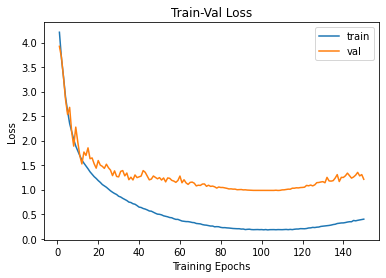

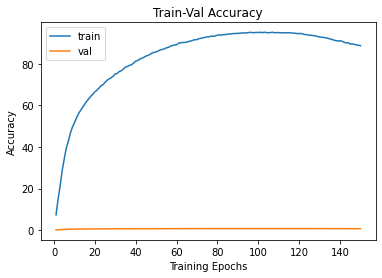

In [67]:
# Train-Validation Progress
num_epochs=150

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_history["train"][:150],label="train")
plt.plot(range(1,num_epochs+1),loss_history["val"][:150],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_history["train"][:150],label="train")
plt.plot(range(1,num_epochs+1),metric_history["val"][:150],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

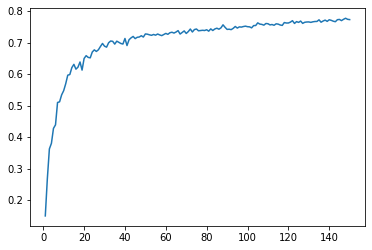

In [53]:
print(metric_history['val'])


[0.1504, 0.268, 0.3629, 0.3806, 0.428, 0.4393, 0.5102, 0.5123, 0.5343, 0.5477, 0.5697, 0.5969, 0.5987, 0.6208, 0.6311, 0.6159, 0.6223, 0.6387, 0.6129, 0.6498, 0.6587, 0.6532, 0.6518, 0.6703, 0.6771, 0.6721, 0.6774, 0.6878, 0.6974, 0.6888, 0.6857, 0.6996, 0.7052, 0.7042, 0.6954, 0.7047, 0.7012, 0.6973, 0.6956, 0.7132, 0.6908, 0.7092, 0.7152, 0.7197, 0.7128, 0.717, 0.7179, 0.7219, 0.7178, 0.7276, 0.7268, 0.7248, 0.7233, 0.7259, 0.7237, 0.7274, 0.7245, 0.7223, 0.726, 0.7293, 0.7264, 0.7314, 0.733, 0.7304, 0.7337, 0.7381, 0.7273, 0.7321, 0.7372, 0.7292, 0.7351, 0.7432, 0.7338, 0.7415, 0.7433, 0.7376, 0.7384, 0.7392, 0.7385, 0.7409, 0.7364, 0.7436, 0.7385, 0.7434, 0.7458, 0.7426, 0.7469, 0.7565, 0.7487, 0.742, 0.7426, 0.7413, 0.7454, 0.7513, 0.7462, 0.75, 0.7493, 0.7511, 0.7523, 0.7506, 0.7501, 0.7469, 0.7541, 0.7543, 0.7627, 0.7589, 0.7579, 0.7555, 0.7607, 0.76, 0.7563, 0.7575, 0.7551, 0.7597, 0.7588, 0.756, 0.7547, 0.7637, 0.7623, 0.7623, 0.7651, 0.7696, 0.7609, 0.7667, 0.7642, 0.7685, 0.